In [1]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense # fully connected
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
import matplotlib.image as mpimg
import cv2
import ntpath
import random 
import pickle
import pandas as pd
import os
from imgaug import augmenters as iaa
%matplotlib inline

In [2]:
# get the training data
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [3]:
!ls track/

driving_log.csv  IMG


In [4]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), 
                   names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [6]:
# remove the C:\ etc local addresses
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [7]:
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

<BarContainer object of 25 artists>

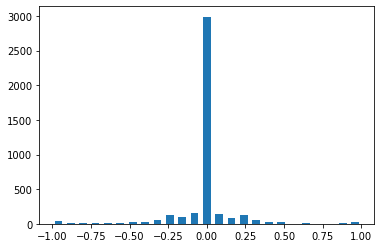

In [8]:
# apparently, going straight (0 degree steering) is wayyy too common
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center,hist,width=0.05)

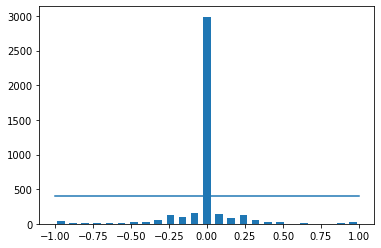

In [9]:
samples_per_bin = 400
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [10]:
# We wanna have at most 400 images from each bins of steering angles
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

data.drop(data.index[remove_list],inplace=True)


<BarContainer object of 25 artists>

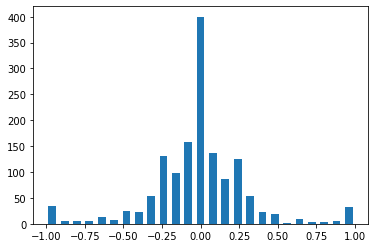

In [11]:
# much more equally distributed steering angles now
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center,hist,width=0.05)

In [12]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.array(image_path)
  steerings = np.array(steering)
  return image_paths, steerings

In [13]:
image_paths, steerings = load_img_steering(datadir+'/IMG',data)

In [14]:
# splitting training-validation. We don't need test data, since the model will be run directly on the simulator
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size = 0.2, random_state=6)


Text(0.5, 1.0, 'Validation set')

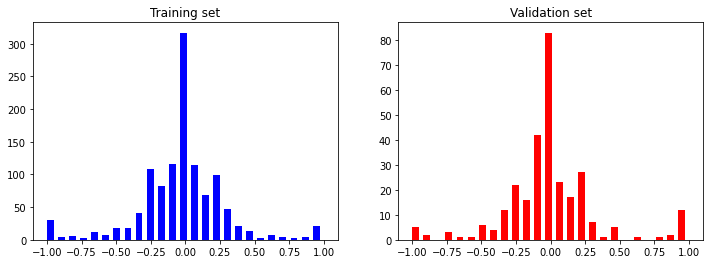

In [15]:
# training and validation sets seem to have similar distributions. Cool!
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].hist(y_train, bins = num_bins, width = 0.05, color='blue')
axs[0].set_title("Training set")
axs[1].hist(y_valid, bins = num_bins, width = 0.05, color='red')
axs[1].set_title("Validation set")

In [16]:
# basic processing of images to make them compatible to the NVIDIA CNN model
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:] #crop height
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # recommended for NVIDIA model
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img, (200,66))
  return img/255

Text(0.5, 1.0, 'preprocessed')

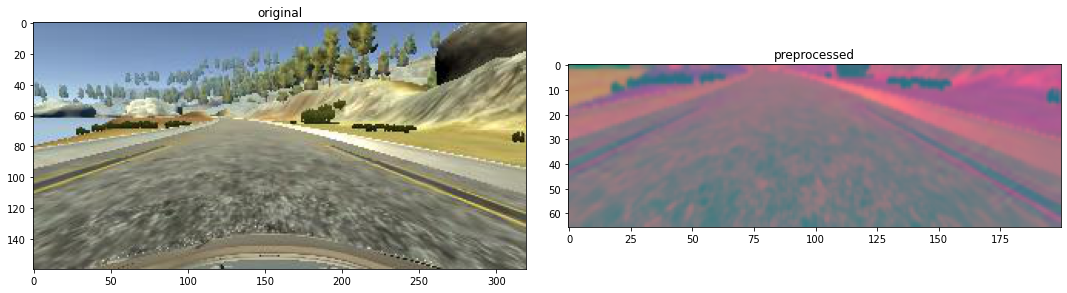

In [17]:
# just seeing how the processed images look
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed')

In [18]:
# apply the processing on all images
X_train = np.array(list(map(img_preprocess,X_train)))
X_valid = np.array(list(map(img_preprocess,X_valid)))

In [19]:
def nvidia_model():
  model = Sequential()
  # relu results in a lot of dead nodes
  
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer= Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [20]:
model = nvidia_model()

In [21]:
history = model.fit(X_train,y_train, epochs = 30, validation_data=(X_valid,y_valid),
          batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
12/12 [==============================] - 4s 75ms/step - loss: 0.8040 - val_loss: 0.1314
Epoch 2/30
12/12 [==============================] - 0s 24ms/step - loss: 0.2521 - val_loss: 0.1104
Epoch 3/30
12/12 [==============================] - 0s 25ms/step - loss: 0.1455 - val_loss: 0.1059
Epoch 4/30
12/12 [==============================] - 0s 24ms/step - loss: 0.1157 - val_loss: 0.1014
Epoch 5/30
12/12 [==============================] - 0s 24ms/step - loss: 0.0965 - val_loss: 0.0978
Epoch 6/30
12/12 [==============================] - 0s 25ms/step - loss: 0.1153 - val_loss: 0.0967
Epoch 7/30
12/12 [==============================] - 0s 25ms/step - loss: 0.0933 - val_loss: 0.0927
Epoch 8/30
12/12 [==============================] - 0s 24ms/step - loss: 0.0989 - val_loss: 0.0905
Epoch 9/30
12/12 [==============================] - 0s 25ms/step - loss: 0.0949 - val_loss: 0.0864
Epoch 10/30
12/12 [==============================] - 0s 23ms/step - loss: 0.0964 - val_loss: 0.0781
Epoch 11/

Text(0.5, 0, 'epoch')

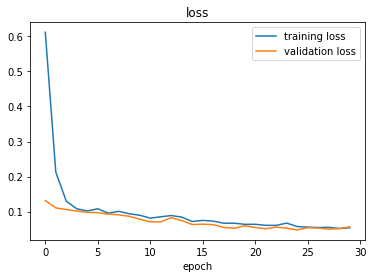

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss","validation loss"])
plt.title("loss")
plt.xlabel("epoch")

In [23]:
# model.save('model.h5')

# from google.colab import files
# files.download('model.h5')

# Creating our own data generator

In [24]:
# We'll stick to four operations for data augmentation. There are loads more in the iaa library

def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1,0.1),"y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1) # -1 means combination of horz and vert flip
  steering_angle = -1*steering_angle #flip the steering angle too
  return image, steering_angle


Text(0.5, 1.0, 'flipped altered')

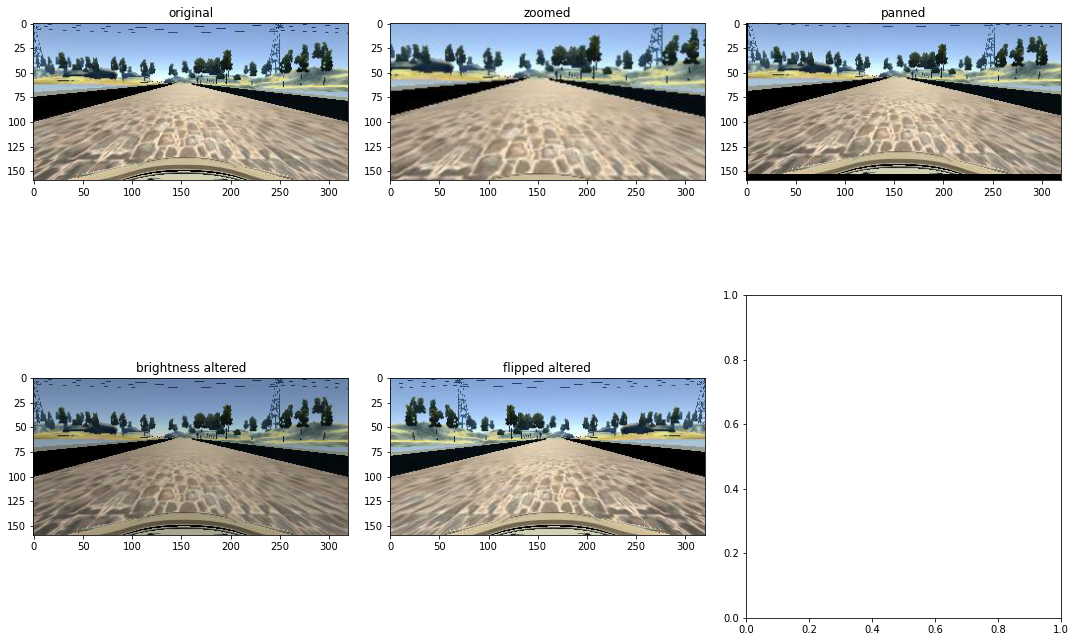

In [25]:
# just checking how the augment images look like
random_index = random.randint(1,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
panned_image = pan(original_image)
brightness_altered_image = img_random_brightness(original_image)
flipped_image,steering_angle = img_random_flip(original_image,steering_angle)

fig, axs = plt.subplots(2,3,figsize=(15,10))
fig.tight_layout()
axs[0][0].imshow(original_image)
axs[0][0].set_title('original')
axs[0][1].imshow(zoomed_image)
axs[0][1].set_title('zoomed')
axs[0][2].imshow(panned_image)
axs[0][2].set_title('panned')
axs[1][0].imshow(brightness_altered_image)
axs[1][0].set_title('brightness altered')
axs[1][1].imshow(flipped_image)
axs[1][1].set_title('flipped altered')


In [26]:
# We won't generate augment versions for ALL images. Will do a coin toss for each effect with p=0.5
def random_augment(image,steering_angle):
  image = mpimg.imread(image)
  if np.random.rand()<0.5:
    image = pan(image)
  if np.random.rand()<0.5:
    image = zoom(image)
  if np.random.rand()<0.5:
    image = img_random_brightness(image)
  if np.random.rand()<0.5:
    image,steering_angle = img_random_flip(image,steering_angle)
  return image,steering_angle 

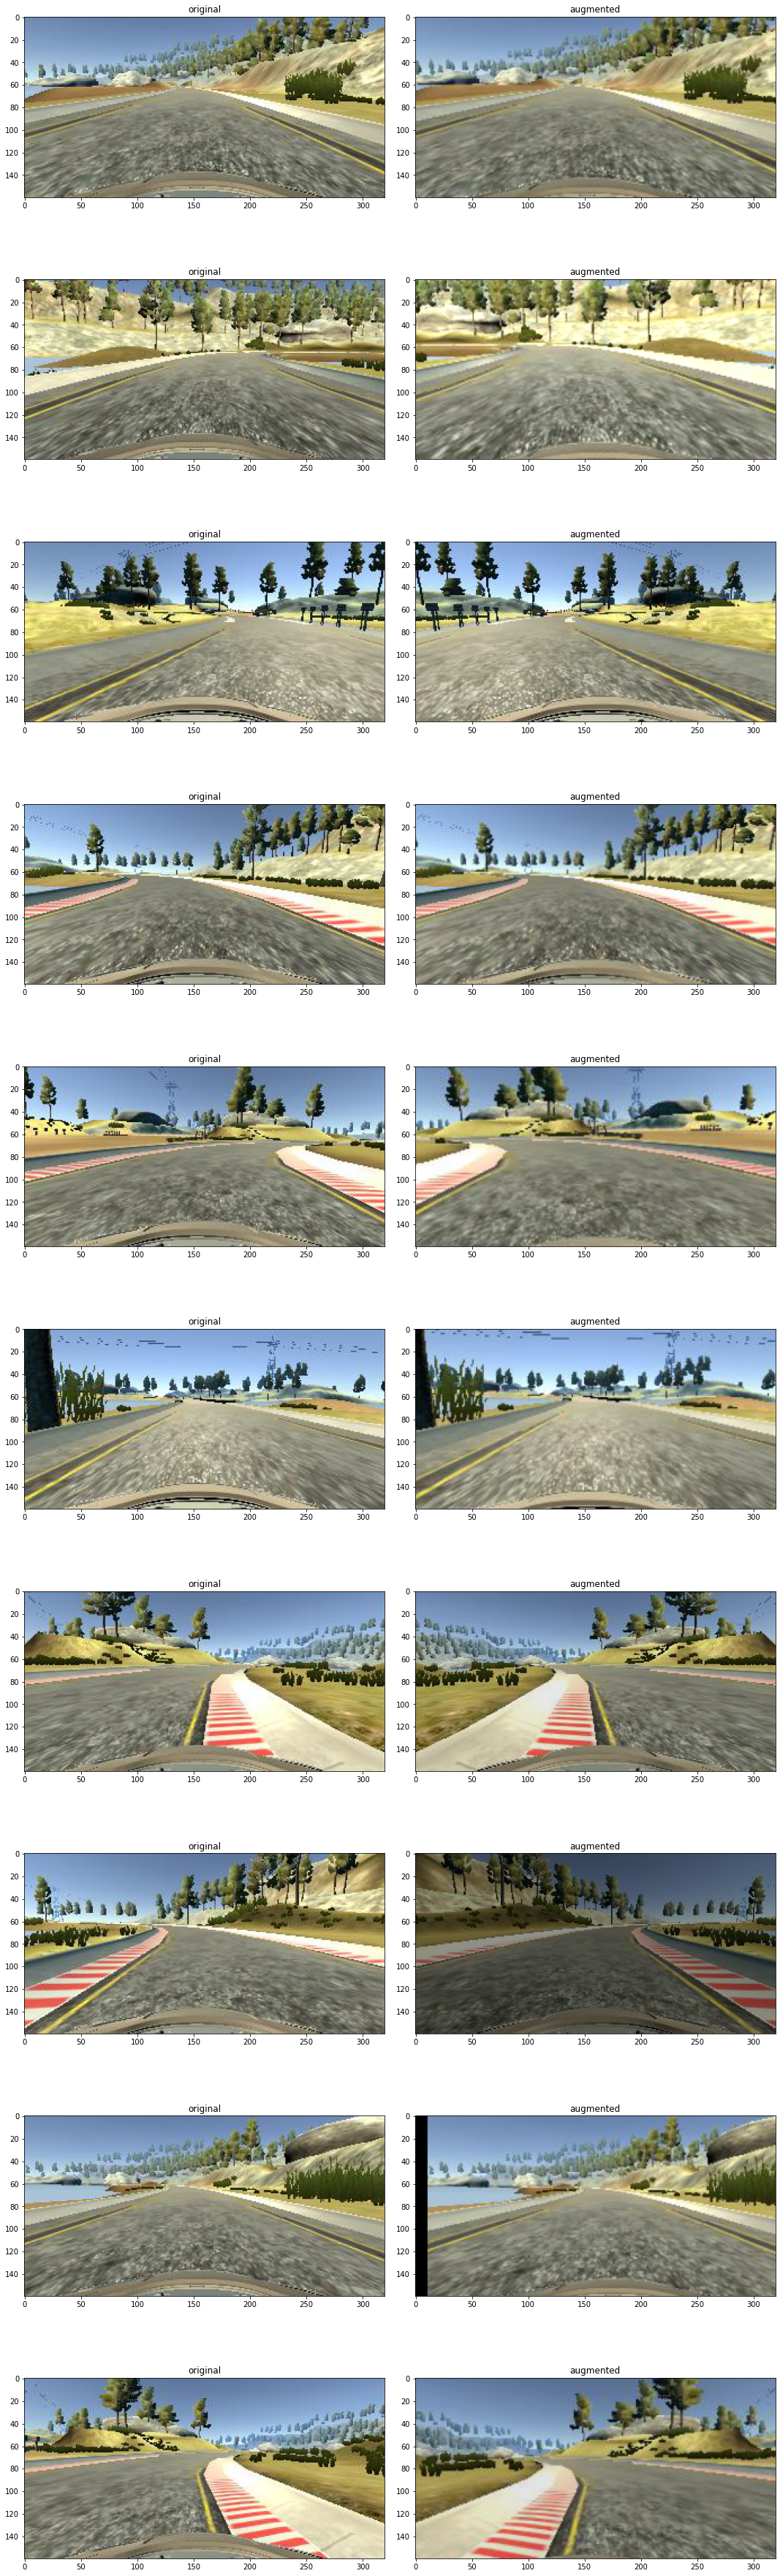

In [27]:
# any of the four effects independently occur in the augment images
fig, axs = plt.subplots(10,2,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0,len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image,random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("original")
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("augmented")

In [28]:
# the imread will be done elsewhere
def img_preprocess_batch(img):
  # img = mpimg.imread(img)
  img = img[60:135,:,:] #crop height
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # recommended for NVIDIA model
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img, (200,66))
  return img/255

In [29]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess_batch(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [30]:
# re-generating the training images to ensure they are uncorrupted
image_paths, steerings = load_img_steering(datadir+'/IMG',data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings, test_size = 0.2, random_state=6)


Text(0.5, 1.0, 'validation')

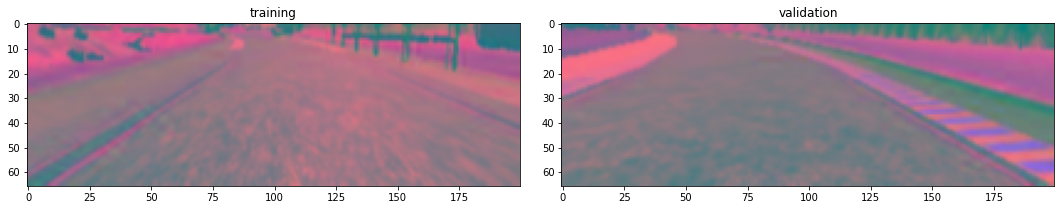

In [31]:
X_train_gen,y_train_gen = next(batch_generator(X_train,y_train,1,1))
X_valid_gen,y_valid_gen = next(batch_generator(X_valid,y_valid,1,0))

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[0].set_title('training')

axs[1].imshow(X_valid_gen[0])
axs[1].set_title('validation')


In [32]:
# for better generalization, remove the dropouts
def nvidia_model_augment():
  model = Sequential()
  # relu results in a lot of dead nodes
  
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(10, activation ='elu'))
  # model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer= Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [33]:
model = nvidia_model_augment()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [34]:
history = model.fit_generator(batch_generator(X_train, y_train, 100,1),
                            steps_per_epoch=300,
                            epochs=10,
                            validation_data=batch_generator(X_valid, y_valid, 100, 0),
                            validation_steps=200,
                            verbose=1,
                            shuffle = 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 183s 611ms/step - loss: 0.4168 - val_loss: 0.0859
Epoch 2/10
300/300 [==============================] - 185s 617ms/step - loss: 0.0737 - val_loss: 0.0604
Epoch 3/10
300/300 [==============================] - 182s 608ms/step - loss: 0.0612 - val_loss: 0.0520
Epoch 4/10
300/300 [==============================] - 182s 610ms/step - loss: 0.0552 - val_loss: 0.0451
Epoch 5/10
300/300 [==============================] - 180s 603ms/step - loss: 0.0521 - val_loss: 0.0439
Epoch 6/10
300/300 [==============================] - 181s 604ms/step - loss: 0.0457 - val_loss: 0.0370
Epoch 7/10
300/300 [==============================] - 182s 609ms/step - loss: 0.0416 - val_loss: 0.0325
Epoch 8/10
300/300 [==============================] - 184s 615ms/step - loss: 0.0390 - val_loss: 0.0358
Epoch 9/10
300/300 [==============================] - 184s 615ms/step - loss: 0.0385 - val_loss: 0.0285
Epoch 10/10
300/300 [==============================] - 184s 616m

Text(0.5, 0, 'Epoch')

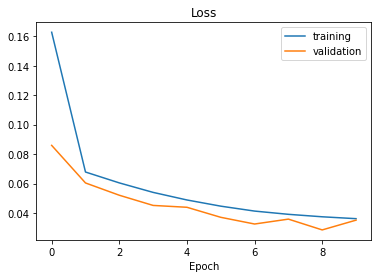

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [36]:
# save the output model
model.save('model_augmented.h5')
from google.colab import files
files.download('model_augmented.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>